In [29]:
def reproduceResult():
  seed_value= 0

  
  with tf.device("/gpu:0"):
    ...


  os.environ['PYTHONHASHSEED']=str(seed_value)
  np.random.seed(0)
  rn.seed(0)


  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, 
                                          inter_op_parallelism_threads=1)


  tf.compat.v1.set_random_seed(seed_value)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.compat.v1.keras.backend.clear_session()

  


In [30]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import os 
import numpy as np
import tensorflow as tf
import random as rn
from tensorflow import keras

reproduceResult()
# %tensorflow_version 2.x
# import tensorflow as tf
# tf.test.gpu_device_name()
# from scipy import integrate
# import os
# import numpy as np
# from tensorflow import keras
import tempfile
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K


from tensorflow.keras import callbacks

from keras_lr_finder import LRFinder
from clr.clr_callback import CyclicLR

import tensorflow_model_optimization as tfmot

import tqdm

import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from attention import Attention

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math


from keras.preprocessing.text import Tokenizer


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing

from bnlp import SentencepieceTokenizer
import gensim
import fasttext 

In [31]:
df = pd.read_csv('Bengali_Banglish_80K_Dataset.csv')

In [32]:
df.head

<bound method NDFrame.head of                                                  Bengali     Label  \
0      এখানে কাওকে কবর দিয়ো না তাহলে তোমাদের পরিবারের...      fear   
1      কিন্ত ভয় কিসের থেকে আমি জানতামনা কিন্ত আমার মন...      fear   
2      করোনাভাইরাস থেকে সৃষ্ট রোগ কভিড১৯ বিশ্বব্যাপী ...      fear   
3      চিতাও তার দিকে এগোতে সাহস পাচ্ছে না দুদিনের অন...      fear   
4      রানী মেরি টিউডরের প্রেতাত্মা এটাআজ চেষ্টা করলা...      fear   
...                                                  ...       ...   
80093  কী ম্যাচিউর একটা কাজ! আশফাক নিপুনরা আছে বলেই এ...   disgust   
80094  সত্যটা কি সেটা আসলে জান্তে পারলাম না । আর পুরা...  surprise   
80095  এভাবেই পুরুষেরা পার পেয়ে যায়।কিন্তু তাদের চোখে...  surprise   
80096  যদিও আফরান নিশু বস আছে বসের নাটক বাদ দেয় না তা...   disgust   
80097  নাটক বলে এগুলা কে রহস্য মুভির স্বাদ পেলাম আর অ...  surprise   

                                                Banglish  
0      ekhane kaoke kobor diyo na tahole tomader pori...  
1      kint

In [33]:
df.isnull()

,Bengali,Label,Banglish
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
80093,False,False,False
80094,False,False,False
80095,False,False,False
80096,False,False,False


In [34]:
df.dropna(inplace=True)

In [35]:
df.groupby("Label").describe()

Bengali                                                            \
           count unique                                                top   
Label                                                                        
anger      15179  15179  নিউ মার্কেট সংঘর্ষের ঘটনাটিকেও রাজনৈতিক রুপ দে...   
disgust    13098  13098                এই ভাবেই আইনের শাষন প্রতিষ্ঠা করেন?   
fear        7565   7565  এখানে কাওকে কবর দিয়ো না তাহলে তোমাদের পরিবারের...   
joy        17836  17836  হা হা হা হো হো হো হি হি হি পালাবি কোথায় রে কালিয়া   
sadness    16309  16309                                       আখেরি জামানা   
surprise   10107  10107                                              কেমনে   

              Banglish         \
         freq    count unique   
Label                           
anger       1    15179  15108   
disgust     1    13098  13051   
fear        1     7565   6997   
joy         1    17836  17779   
sadness     1    16309  16252   
surprise    1    10107  10076   

                                                                  
                                                        top freq  
Label                                                             
anger                                       batil kora ucit    3  
disgust   kotto boro cor... 15/20 bochor dhore je jontro...    2  
fear      ekhane kaoke kobor diyo na tahole tomader pori...    2  
joy                                     ek kothay osadharon    4  
sadness   konodol somarthonkari bjakti sorbojon shrodhdh...    2  
surprise  bangla o hindi coloccitre jemon chilen oprihar...    2

In [36]:
df["Label"].value_counts()

joy         17836
sadness     16309
anger       15179
disgust     13098
surprise    10107
fear         7565
Name: Label, dtype: int64

In [37]:
df['Banglish'] = df['Banglish'].astype(str)

In [38]:
train, test = train_test_split(df, test_size=0.2, stratify = df["Label"], random_state = 42)
num_classes = 6
embed_num_dims = 300
max_seq_len = 50

x_train = train['Banglish']
x_test = test['Banglish']

y_train = train['Label']
y_test = test['Label']

texts_train = x_train
texts_test = x_test

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Banglish'])

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len, padding='pre' )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len,  padding='pre')

print(X_train_pad)


encoding = {
    "joy":0,
    "disgust":1,
    "sadness":2,
    "anger":3,
    "fear":4,
    "surprise":5
}

y_train = [encoding[x] for x in train['Label']]
y_test = [encoding[x] for x in test['Label']]



y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


Number of unique words: 78451
[[    0     0     0 ...   777    30   903]
 [    0     0     0 ...  7624  2009    79]
 [    0     0     0 ...   770   259  6571]
 ...
 [    0     0     0 ...  5375    20   327]
 [    0     0     0 ...   780   677  9468]
 [    0     0     0 ...     2 78451    63]]


In [39]:
# META EMBADDING

In [40]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open('F:/Python_code/embedding/cc.bn.300.vec',encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix


embedd_matrix_fasttext = create_embedding_matrix(index_of_words, embed_num_dims)
print(embedd_matrix_fasttext.shape)

(78452, 300)


# Random Search

In [41]:
from tensorflow.keras import regularizers
import time
LOG_DIR = f"{int(time.time())}"
seed_value= 0



def build_model(hp):
  
  reproduceResult()

  print('Ya it comes here')

  lstm_unit = hp.Int("lstm_unit",min_value =64, max_value = 256, step = 32)
  lstm_dropout = hp.Float("lstm_dropout",min_value = 0.1,max_value = 0.5,step = 0.1)




  seq_input = keras.layers.Input(shape=(max_seq_len,))

  embedded = keras.layers.Embedding(vocab_size,
                          embed_num_dims,
                          input_length = max_seq_len,
                          weights = [embedd_matrix_fasttext])(seq_input)

  lstm = keras.layers.Bidirectional(keras.layers.LSTM(lstm_unit, recurrent_regularizer=regularizers.l2(1e-4),
                                                      return_sequences=True,kernel_regularizer=regularizers.l2(1e-4),
                                                      bias_regularizer=regularizers.l2(1e-2),
                                                      activity_regularizer=regularizers.l2(1e-4),input_shape =(48,)))(embedded)
  lstm = keras.layers.Activation(activation='relu')(lstm)
  lstm = keras.layers.BatchNormalization()(lstm)
  lstm = keras.layers.Dropout(lstm_dropout,seed=seed_value)(lstm)
  
  
  max_pooling = keras.layers.GlobalMaxPooling1D()(lstm)
  output = keras.layers.Dense(num_classes, activation='softmax')(max_pooling)

  model = keras.Model(inputs = [seq_input], outputs = output)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

  return model


stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              restore_best_weights=True,
                              verbose=0, mode='max')


clr_step_size = int((len(X_train_pad)/64))
base_lr = 1e-3
max_lr = 6e-3
mode = 'exp_range'


clr = CyclicLR(base_lr = base_lr, max_lr = max_lr, step_size = clr_step_size, mode = mode)



tuner = RandomSearch(
    build_model,
    objective = keras_tuner.Objective('val_accuracy', direction="max"),
    max_trials = 20,
    executions_per_trial = 1,
    directory = LOG_DIR
    )
  
tuner.search(x=X_train_pad,y = y_train,epochs = 30, batch_size = 64,callbacks = [stop,clr], 
             validation_data = (X_test_pad,y_test))


tuner.results_summary()

Trial 20 Complete [00h 03m 28s]
val_accuracy: 0.5808727145195007

Best val_accuracy So Far: 0.5985392332077026
Total elapsed time: 01h 07m 21s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1709377176\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
lstm_unit: 128
lstm_dropout: 0.2
Score: 0.5985392332077026

Trial 13 summary
Hyperparameters:
lstm_unit: 64
lstm_dropout: 0.2
Score: 0.5971658825874329

Trial 08 summary
Hyperparameters:
lstm_unit: 64
lstm_dropout: 0.1
Score: 0.5943567156791687

Trial 14 summary
Hyperparameters:
lstm_unit: 224
lstm_dropout: 0.2
Score: 0.5915475487709045

Trial 10 summary
Hyperparameters:
lstm_unit: 192
lstm_dropout: 0.2
Score: 0.5907984375953674

Trial 15 summary
Hyperparameters:
lstm_unit: 128
lstm_dropout: 0.1
Score: 0.590673565864563

Trial 01 summary
Hyperparameters:
lstm_unit: 128
lstm_dropout: 0.30000000000000004
Score: 0.5903614163398743

Trial 12 summary
Hype

In [42]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
lstm_unit (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
lstm_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [43]:
#get best hypoerparamter
best_hps = tuner.get_best_hyperparameters()[0]
model = build_model(best_hps)

Ya it comes here


In [44]:
history = model.fit(x=X_train_pad,y = y_train,epochs = 30, batch_size = 64,callbacks = [stop,clr], 
             validation_data = (X_test_pad,y_test))

Epoch 1/30
1002/1002 [==============================] - 31s 28ms/step - loss: 1.9115 - accuracy: 0.5295 - val_loss: 1.2271 - val_accuracy: 0.5649
Epoch 2/30
1002/1002 [==============================] - 28s 27ms/step - loss: 0.9064 - accuracy: 0.7152 - val_loss: 1.1901 - val_accuracy: 0.5947
Epoch 3/30
1002/1002 [==============================] - 27s 27ms/step - loss: 0.5264 - accuracy: 0.8527 - val_loss: 1.5671 - val_accuracy: 0.5467
Epoch 4/30
1002/1002 [==============================] - 27s 27ms/step - loss: 0.4815 - accuracy: 0.8733 - val_loss: 1.5802 - val_accuracy: 0.5641
Epoch 5/30
1002/1002 [==============================] - 27s 27ms/step - loss: 0.3112 - accuracy: 0.9300 - val_loss: 1.9956 - val_accuracy: 0.5272
Epoch 6/30
1002/1002 [==============================] - 27s 27ms/step - loss: 0.3777 - accuracy: 0.9161 - val_loss: 1.9588 - val_accuracy: 0.5565
Epoch 7/30
1002/1002 [==============================] - 27s 27ms/step - loss: 0.2641 - accuracy: 0.9468 - val_loss: 2.2672 -

In [45]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

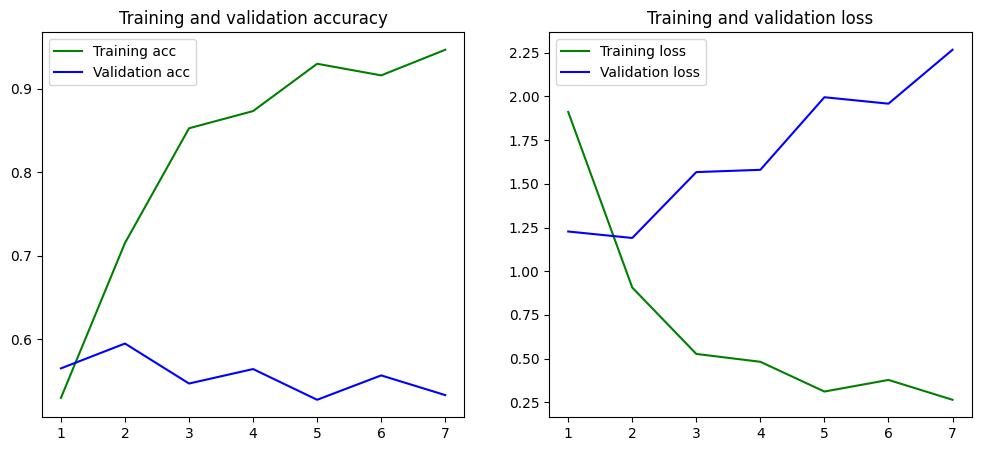

In [46]:
PlotGraph(history)

In [47]:
predict = model.predict(X_test_pad)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

501/501 [==============================] - 3s 6ms/step


array([0, 4, 3, ..., 1, 3, 5], dtype=int64)

In [48]:
predict_lables=np.argmax(y_test, axis=1)
predict_lables

array([0, 3, 1, ..., 1, 3, 4], dtype=int64)

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predict_lables, predict_class)
cm

array([[2829,   70,  223,  175,   49,  221],
       [ 157, 1406,  314,  543,   72,  128],
       [ 391,  318, 1706,  587,   97,  163],
       [ 301,  569,  486, 1423,   87,  170],
       [  82,  136,   99,  109,  968,  119],
       [ 258,  140,  163,  160,  106, 1194]], dtype=int64)

In [50]:
class_names = list(encoding.keys())

In [51]:
print(class_names)

['joy', 'disgust', 'sadness', 'anger', 'fear', 'surprise']


<Axes: >

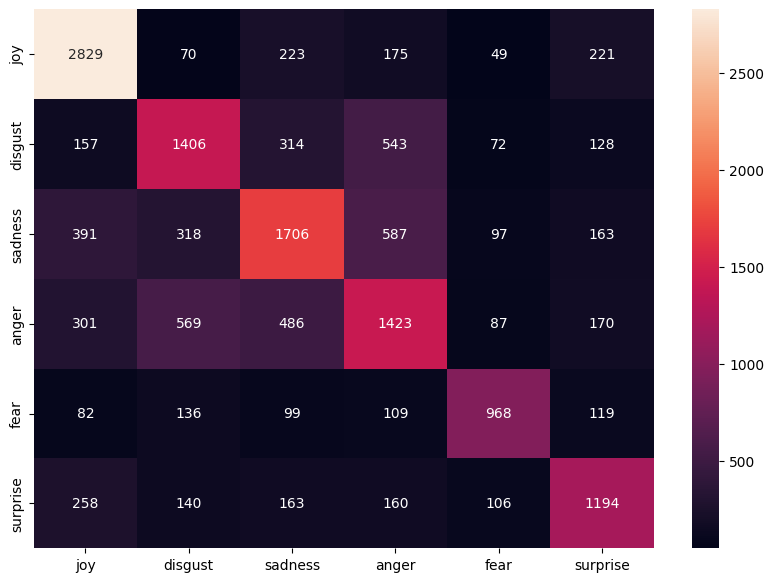

In [52]:
df_cm = pd.DataFrame(cm, index=class_names,columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [53]:
from sklearn.metrics import classification_report
print(classification_report(predict_lables, predict_class, target_names =class_names))

              precision    recall  f1-score   support

         joy       0.70      0.79      0.75      3567
     disgust       0.53      0.54      0.53      2620
     sadness       0.57      0.52      0.55      3262
       anger       0.47      0.47      0.47      3036
        fear       0.70      0.64      0.67      1513
    surprise       0.60      0.59      0.59      2021

    accuracy                           0.59     16019
   macro avg       0.60      0.59      0.59     16019
weighted avg       0.59      0.59      0.59     16019

